In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats


In [6]:

# Load Excel file
df = pd.read_excel("EastWestAirlines.xlsx", sheet_name='data')




Preprocessed data shape: (3630, 10)


In [7]:
# Drop ID and target column for clustering
df_cluster = df.drop(['ID#', 'Award?'], axis=1)



In [8]:
# Drop missing values if any
df_cluster.dropna(inplace=True)





In [9]:
# Remove outliers using Z-score
z_scores = np.abs(stats.zscore(df_cluster))
df_no_outliers = df_cluster[(z_scores < 3).all(axis=1)]



In [10]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_no_outliers)

print("Preprocessed data shape:", df_no_outliers.shape)


Preprocessed data shape: (3630, 10)


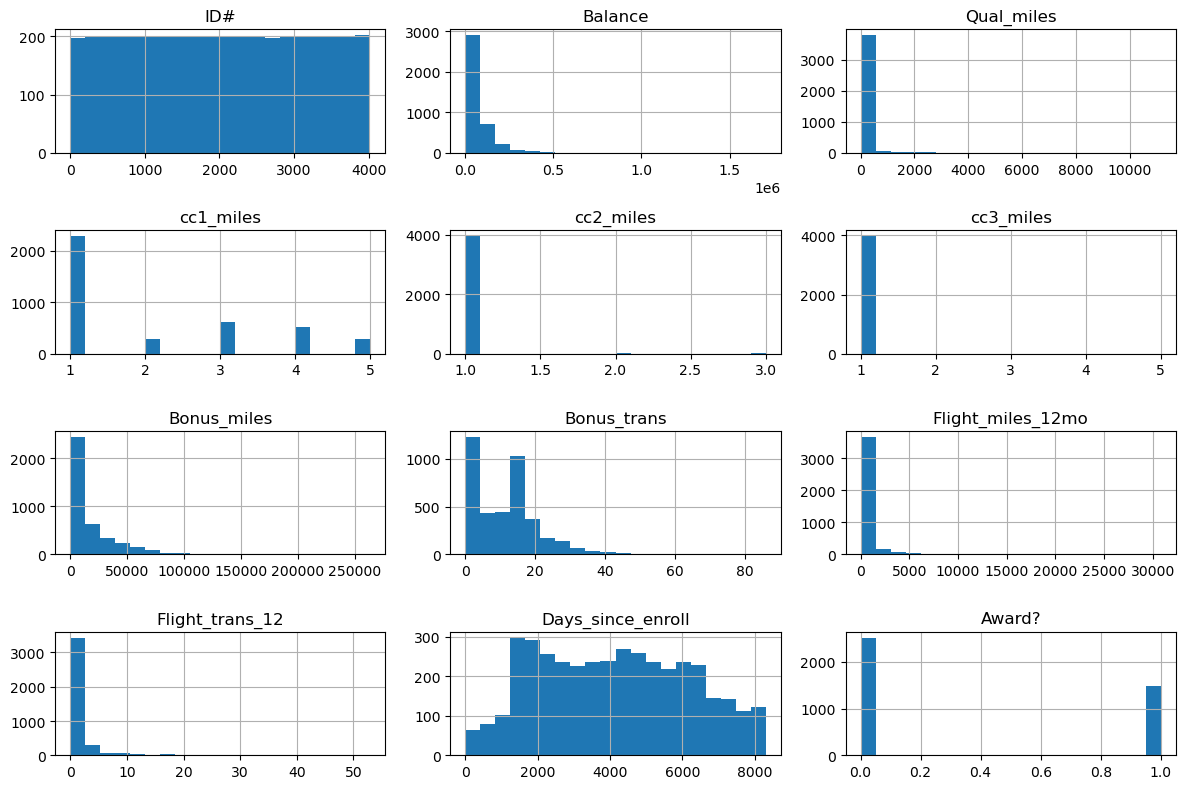

In [12]:
# Histogram for each feature
df.hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()



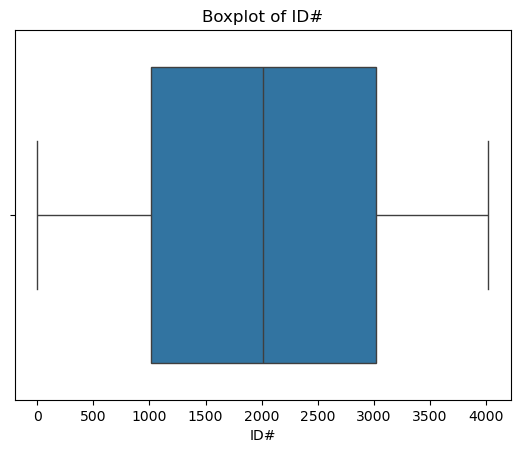

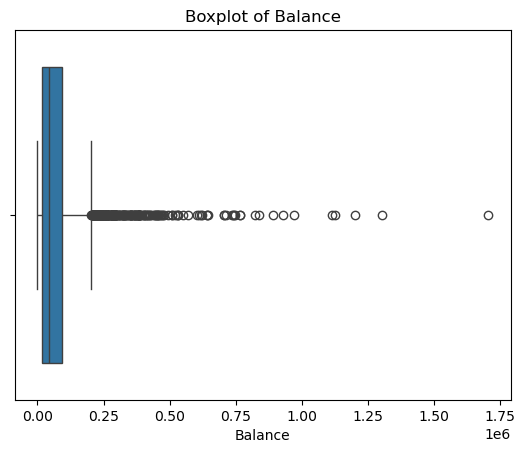

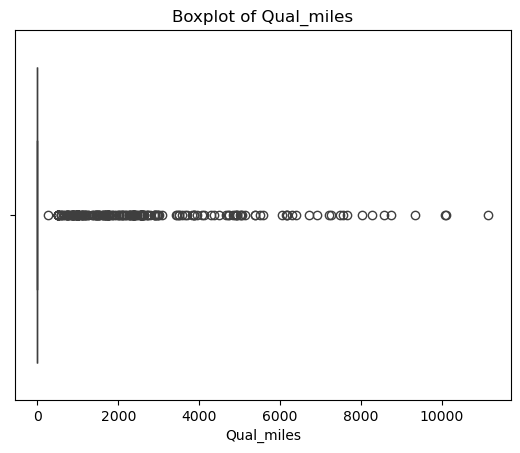

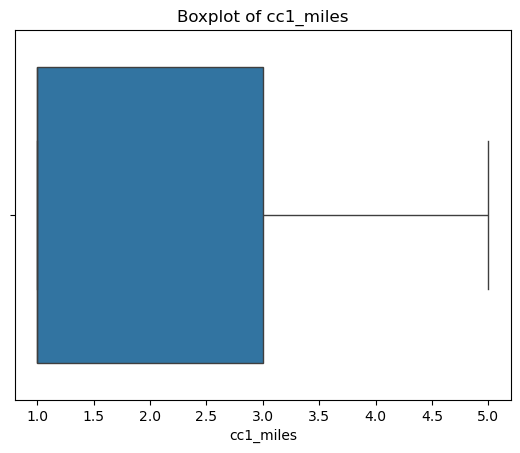

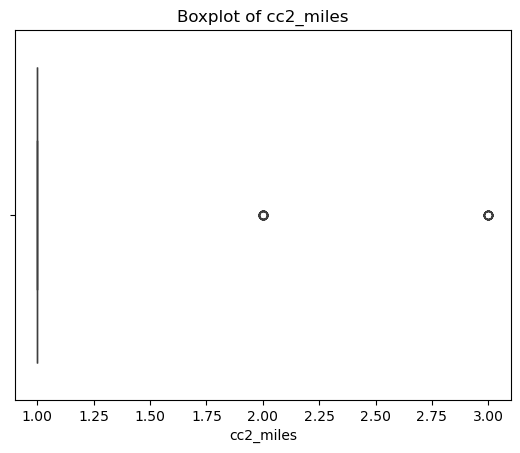

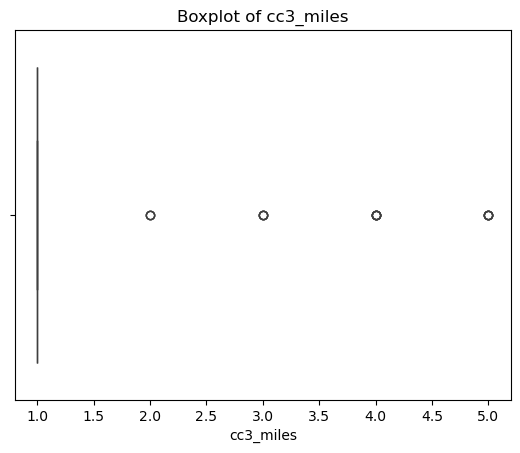

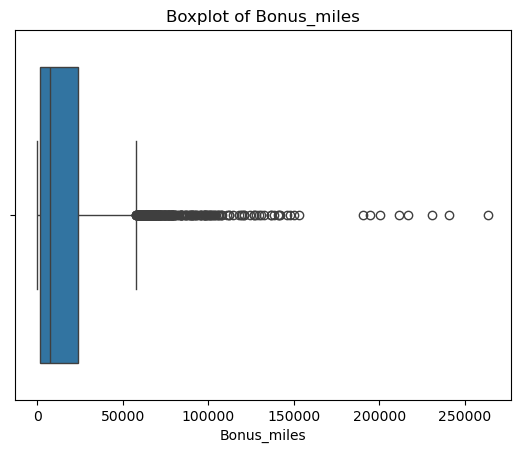

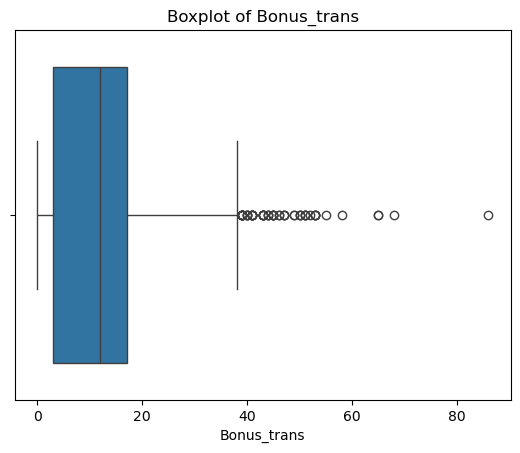

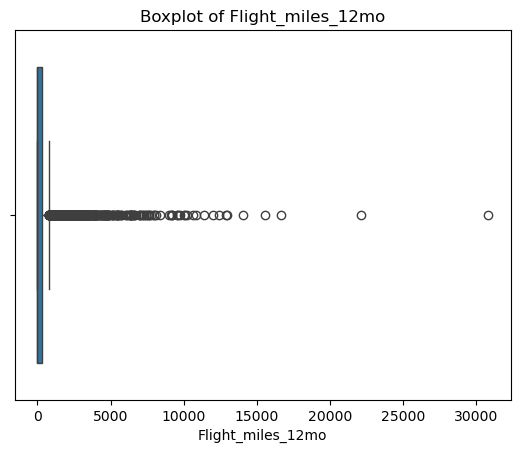

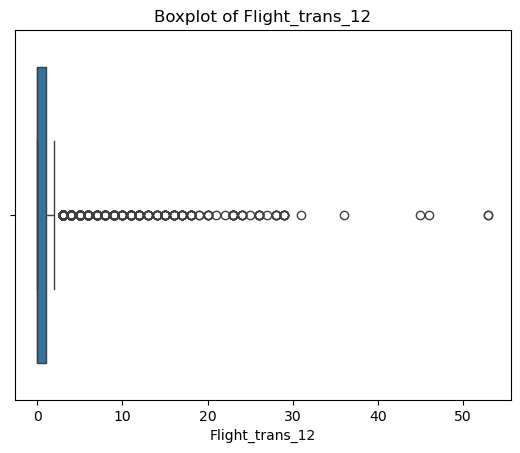

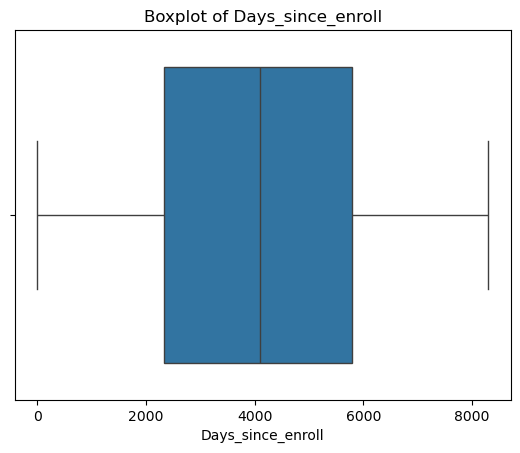

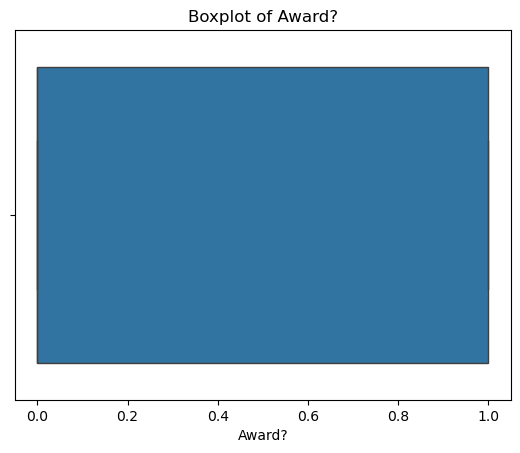

In [16]:
# Boxplots for outlier visualization
for column in df.select_dtypes(include=np.number).columns:
    plt.figure()
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()



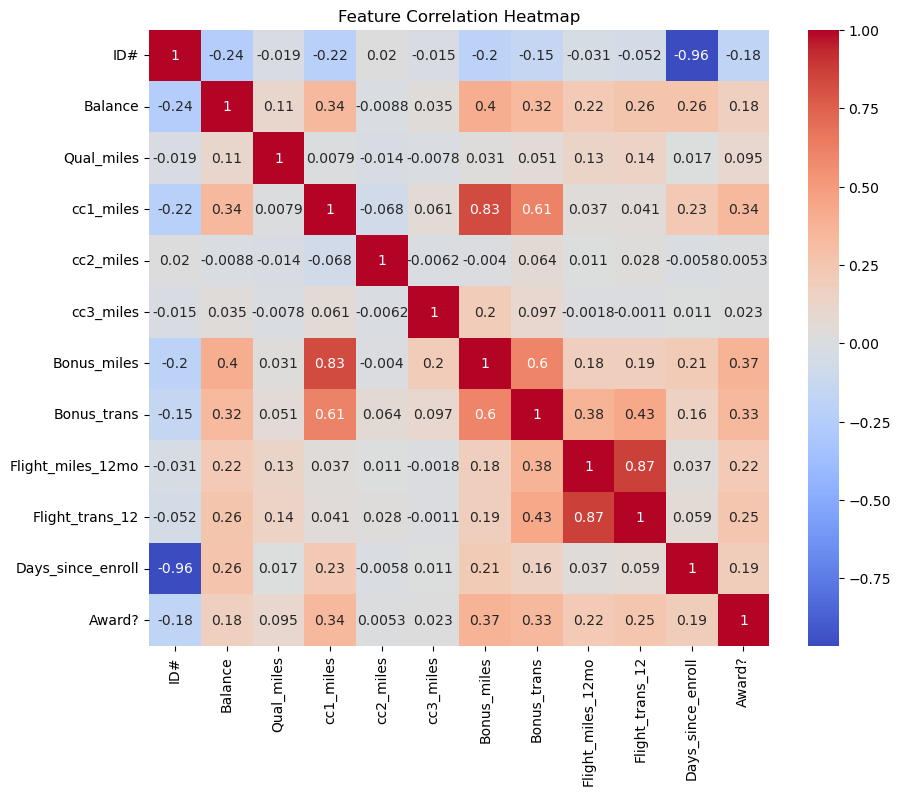

In [17]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [18]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)


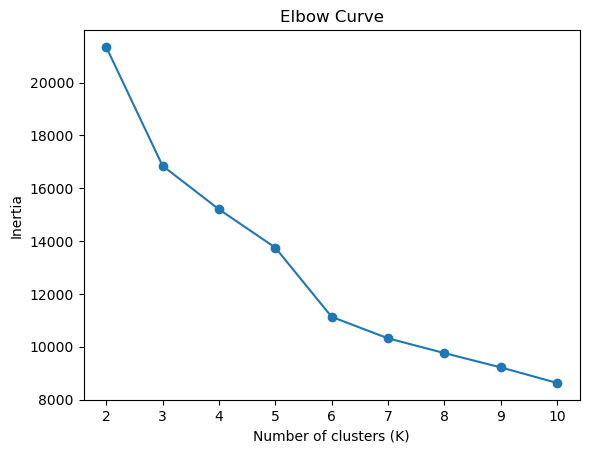

In [19]:
# Elbow Method
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.show()



In [20]:
# Optimal K (assume 3 here)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)



In [21]:
# Silhouette Score
kmeans_silhouette = silhouette_score(scaled_data, kmeans_labels)
print("Silhouette Score (K-Means):", kmeans_silhouette)




Silhouette Score (K-Means): 0.3504137590806388


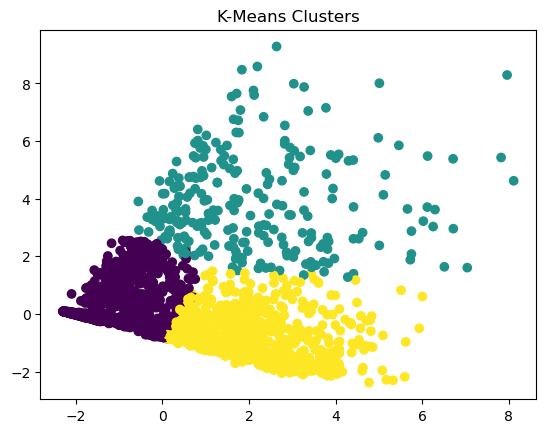

In [22]:
# Visualization
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("K-Means Clusters")
plt.show()

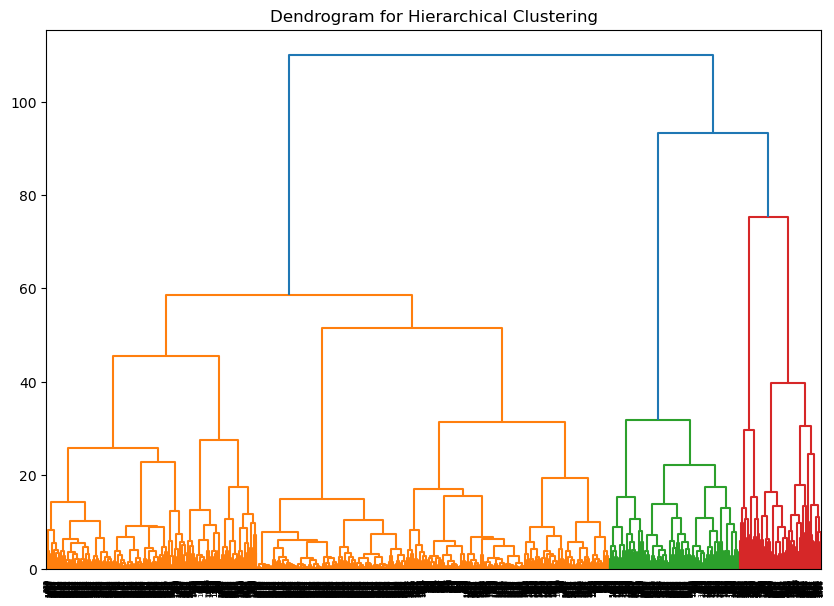

In [27]:
# Dendrogram
linked = linkage(scaled_data, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title("Dendrogram for Hierarchical Clustering")
plt.show()



In [28]:
# Fit model (assume 3 clusters)
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
hc_labels = hc.fit_predict(scaled_data)



In [29]:
# Silhouette Score
hc_silhouette = silhouette_score(scaled_data, hc_labels)
print("Silhouette Score (Hierarchical):", hc_silhouette)




Silhouette Score (Hierarchical): 0.3470868576180811


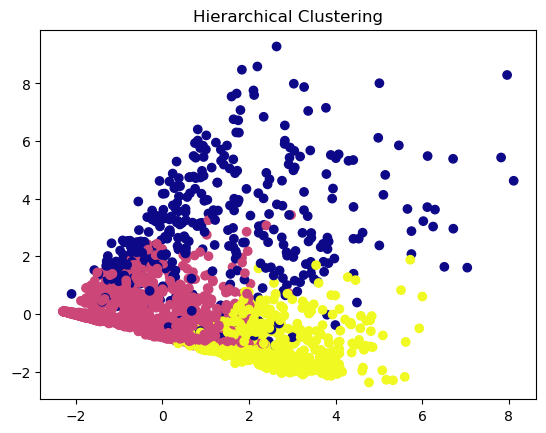

In [30]:
# Visualization
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=hc_labels, cmap='plasma')
plt.title("Hierarchical Clustering")
plt.show()

In [31]:
# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data)



In [32]:
# Check how many clusters (excluding noise)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print("Estimated number of clusters (DBSCAN):", n_clusters_dbscan)



Estimated number of clusters (DBSCAN): 20


In [33]:
# Silhouette Score (excluding noise)
if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(scaled_data, dbscan_labels)
    print("Silhouette Score (DBSCAN):", dbscan_silhouette)
else:
    print("Silhouette Score (DBSCAN): Not applicable (only one cluster detected)")


Silhouette Score (DBSCAN): -0.29654971525490836


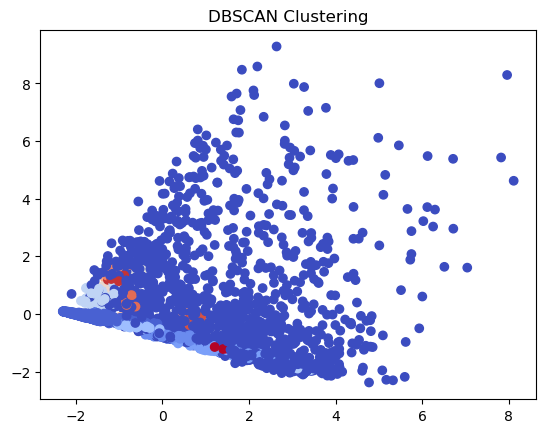

In [34]:

# Visualization
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=dbscan_labels, cmap='coolwarm')
plt.title("DBSCAN Clustering")
plt.show()


In [39]:
# Add KMeans cluster labels back to original data
df_clustered = df_no_outliers.copy()
df_clustered["KMeans_Cluster"] = kmeans_labels
df_clustered["HC_Cluster"] = hc_labels
df_clustered["DBSCAN_Cluster"] = dbscan_labels



In [40]:
# View mean of each cluster (KMeans example)
print(df_clustered.groupby("KMeans_Cluster").mean())


                     Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  \
KMeans_Cluster                                                              
0               36755.204007   29.862933   1.146175        1.0        1.0   
1               97897.225410  157.127049   2.020492        1.0        1.0   
2               96709.280672   33.423529   3.563025        1.0        1.0   

                 Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
KMeans_Cluster                                                                  
0                3663.948087     6.030965          98.770036         0.352914   
1               19236.081967    16.110656        2217.303279         6.274590   
2               32912.934454    17.487395         143.716807         0.457143   

                Days_since_enroll  HC_Cluster  DBSCAN_Cluster  
KMeans_Cluster                                                 
0                     3666.077869    0.948543        0.714481  
1               